<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparing the data</a></span><ul class="toc-item"><li><span><a href="#Gathering-the-data" data-toc-modified-id="Gathering-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Gathering the data</a></span></li><li><span><a href="#Getting-the-venues" data-toc-modified-id="Getting-the-venues-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Getting the venues</a></span></li><li><span><a href="#Normalizing-the-venues" data-toc-modified-id="Normalizing-the-venues-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Normalizing the venues</a></span></li></ul></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Clustering</a></span></li><li><span><a href="#Correlation" data-toc-modified-id="Correlation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Correlation</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

from bs4 import BeautifulSoup
import requests

import json

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

import folium

from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# Preparing the data

We need to create three dataframes, one for each city.

Then we'll concatenate those dataframes (only some columns of course) to create our whole dataset.

For starters, let's get some information about each city.

## Gathering the data

Let's get the neighborhood data first and clean it a bit

In [49]:
url = 'https://www.salairemoyen.com/departement-75-PARIS.html'

data = requests.get(url)
soup = BeautifulSoup(data.content, "html.parser")

arrs = soup.select('td tr+ tr a')

neighborhoods = [arr.text[-6: -1] for arr in arrs]
neighborhoods

['75007',
 '75008',
 '75006',
 '75016',
 '75009',
 '75001',
 '75005',
 '75003',
 '75002',
 '75004',
 '75019',
 '75020',
 '75018',
 '75013',
 '75010',
 '75014',
 '75011',
 '75012',
 '75015',
 '75017']

Moving on to the salaries

In [50]:
soup_salaries = soup.select('td tr+ tr td+ td')


salaries = [int(s.text[:5].replace(' ', '')) for s in soup_salaries]
salaries

[4214,
 4108,
 3793,
 3774,
 3274,
 3168,
 3123,
 3038,
 2976,
 2912,
 1718,
 1858,
 1988,
 2133,
 2433,
 2517,
 2546,
 2552,
 2871,
 2904]

We can now move on to creating the dataframe and build upon it

In [51]:
paris = pd.DataFrame(data=list(zip(neighborhoods, salaries)), columns=['Neighborhood', 'Salary'])
paris.head()

,Neighborhood,Salary
0,75007,4214
1,75008,4108
2,75006,3793
3,75016,3774
4,75009,3274


We will now only use the first dataframe introduced down below but you could potentially decide to switch to the more complex df2.

In [52]:
df1 = pd.read_json('../data/correspondances-code-insee-code-postal.json')
df2 = pd.read_json('../data/quartier_paris.json')

In [53]:
df1['Neighborhood'] = df1['fields'].apply(lambda x: x['postal_code'])
df1['Latitude'] = df1['fields'].apply(lambda x: x['geo_point_2d'][0])
df1['Longitude'] = df1['fields'].apply(lambda x: x['geo_point_2d'][1])

df1 = df1[['Neighborhood', 'Latitude', 'Longitude']]

df1 = df1[df1['Neighborhood'].isin(neighborhoods)].reset_index(drop=True)

paris = paris.merge(right=df1, on='Neighborhood', how='left')
paris.head()

,Neighborhood,Salary,Latitude,Longitude
0,75007,4214,48.856083,2.312439
1,75008,4108,48.872527,2.312583
2,75006,3793,48.848968,2.332671
3,75016,3774,48.860399,2.262100
4,75009,3274,48.876896,2.337460


Since we want to make clusters with all three cities at the same time, latitude and longitude would not be great features. The distance between the neighborhood and the heart of the city is more relevant.

In [54]:
def get_distance(df, center, lat='Latitude', long='Longitude', normalize=True):
    
    """
    Will calculate the distance between each neighborhood and the center of the town.
    """
    
    x = pd.Series([geodesic((df.iloc[i][lat], df.iloc[i][long]), center) for i in range(len(df))])
    
    if normalize:
        x = x/x.max()
    else:
        x = float(str(x)[:-3]) # Getting rid of the km
    
    return x

In [55]:
paris_coord = (48.85341, 2.3488)

paris['Center_distance'] = get_distance(paris, center=paris_coord, lat='Latitude', long='Longitude')
paris['Neighborhood'] = paris['Neighborhood'].apply(lambda x: x[3:])

paris.head()

,Neighborhood,Salary,Latitude,Longitude,Center_distance
0,07,4214,48.856083,2.312439,0.418888
1,08,4108,48.872527,2.312583,0.530954
2,06,3793,48.848968,2.332671,0.200116
3,16,3774,48.860399,2.262100,1.0
4,09,3274,48.876896,2.337460,0.42767


In [56]:
def create_map(df, coord):
    
    latitude, longitude = coord

    map_city = folium.Map(location=[latitude, longitude], zoom_start=11)

    for lat, lng,  neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city)
    
    return map_city
    
map_paris = create_map(paris, paris_coord)

In [57]:
map_paris

Now to Toronto's turn.

We will use the BeautifulSoup API to scrape data from Wikipedia.

In [8]:
data = requests.get('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1012118802')
soup = BeautifulSoup(data.content, "html.parser")

# Will be available from ../data/toronto_data.csv

Now let's create a list for each future column of our dataframe, and a list of all cells that will be present in the table.

In [3]:
table_contents=[]
table=soup.find('table')
table.findAll('td')
postal_code = []
borough = []
neighborhood = []
cells = [str(cell)[4:-6] for cell in table.findAll('td')]

This way, we can segment all cells the following way : 
* All the $3 \times i$ cells will be postal codes
* All the $3 \times i + 1$ cells will be boroughs
* All the $3 \times i + 2$ cells will be neighborhoods

In [4]:
for i in range(len(cells)//3):
    if cells[3*i+1] == 'Not assigned':
        pass
    else:
        postal_code.append(cells[3*i])
        borough.append(cells[3*i+1])
        neighborhood.append(cells[3*i+2])

Let's now create the dataframe

In [5]:
df = pd.DataFrame(postal_code, columns=['PostalCode'])
df['Borough'] = borough
df['Neighborhood'] = neighborhood


print('Number of rows:', len(df))
print('Number unique postal codes:', df['PostalCode'].nunique())
print('Number of unassigned neighborhoods:', len(df[df['Neighborhood'] == 'Not assigned']))

Number of rows: 103
Number unique postal codes: 103
Number of unassigned neighborhoods: 0


All neighborhoods are assigned and there are no postal codes duplicates, meaning the neighborhoods with the same postal code have been fused into one cell, separated by a comma, as shown below.

Let's get the Latitude/Longitude dataframe and rename its `Postal Code` column to `PostalCode`, so as to be able to execute a pandas merge.

In [62]:
coord = pd.read_csv('../data/Geospatial_Coordinates.csv')
coord = coord.rename(columns={'Postal Code': 'PostalCode'})

Let's now merge the dataframes on the postal code to get the coordinates for each postal code.

In [63]:
df = df.merge(right=coord, on='PostalCode', how='left')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Despite the fact that we will not use it in the remainder of this notebook, we will create the dataframe limited to the Toronto neighborhoods

In [64]:
toronto_df = df['Borough'].apply(lambda x: 'Toronto' in x)
toronto = df[toronto_df].reset_index(drop=True)
print('Shape of the Toronto subset:', toronto.shape)
toronto.head()

Shape of the Toronto subset: (40, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [65]:
address = 'Toronto, Downtown'

geolocator = Nominatim(user_agent="neigh_explorer")
location = geolocator.geocode(address)

toronto_coord = (location.latitude, location.longitude)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}.'.format(toronto_coord))

The geograpical coordinates of Toronto are (43.6541737, -79.38081162653639).


In [66]:
toronto['Center_distance'] = get_distance(toronto, center=toronto_coord, lat='Latitude', long='Longitude')

toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Center_distance
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.184076
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.129245
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.041258
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.059629
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0.847851


In [67]:
toronto_map = create_map(toronto, toronto_coord)
toronto_map

And finally comes New York's turn!

In [68]:
with open('../data/newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [69]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Let's now make a DataFrame from this json file.

In [70]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

ny = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny = ny.append({'Borough': borough,
                    'Neighborhood': neighborhood_name,
                    'Latitude': neighborhood_lat,
                    'Longitude': neighborhood_lon}, ignore_index=True)

ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [71]:
address = 'New York City, Downtown'

geolocator = Nominatim(user_agent="neigh_explorer")
location = geolocator.geocode(address)

ny_coord = (location.latitude, location.longitude)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of New York City are {}.'.format(ny_coord))

The geograpical coordinates of New York City are (40.5997561, -73.9463899).


In [72]:
ny['Center_distance'] = get_distance(ny, center=ny_coord, lat='Latitude', long='Longitude')

ny.head()

,Borough,Neighborhood,Latitude,Longitude,Center_distance
0,Bronx,Wakefield,40.894705,-73.847201,0.980734
1,Bronx,Co-op City,40.874294,-73.829939,0.929289
2,Bronx,Eastchester,40.887556,-73.827806,0.971577
3,Bronx,Fieldston,40.895437,-73.905643,0.957727
4,Bronx,Riverdale,40.890834,-73.912585,0.941332


In [73]:
ny_map = create_map(ny, ny_coord)
ny_map

## Getting the venues

In [74]:
CLIENT_ID = 'IEOO3KWBWYMOL0KIK2LY2Z50FANJYMSLKW1QPSCAN2MOH22Y'
CLIENT_SECRET = 'RDB3ALGA2YT05LIYCRF0V1UN3WOJTSSAOIKROUSEIVNYB5R1'
ACCESS_TOKEN = 'LWOGJGTV0OIKFYA1GRNJS3EALCAMEYP5IM3SCF1ZNVU33EP3'
VERSION = '20210604'
LIMIT = 30

In [75]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [76]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Normalizing the venues

In [77]:
paris_venues = getNearbyVenues(names=paris['Neighborhood'],
                               latitudes=paris['Latitude'],
                               longitudes=paris['Longitude']
                               )

paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

07
08
06
16
09
01
05
03
02
04
19
20
18
13
10
14
11
12
15
17


,Neighborhood,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,Bar,Basque Restaurant,Beer Bar,Beer Store,Bistro,...,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Zoo,Zoo Exhibit
0,07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,07,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                               latitudes=toronto['Latitude'],
                               longitudes=toronto['Longitude']
                               )

toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Runnymede, The Junction, Weston-Pellam Park, Carlton Village
Davisville North
Forest Hill North &amp; West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands,

,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
ny_venues = getNearbyVenues(names=ny['Neighborhood'],
                               latitudes=ny['Latitude'],
                               longitudes=ny['Longitude']
                               )

ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
cols = set(list(ny_onehot.columns) + list(toronto_onehot.columns) + list(paris_onehot.columns)) # All columns possible

In [81]:
cpt = 0
for col in cols:
    if col not in paris_onehot.columns:
        paris_onehot[col] = 0
        
    if col not in toronto_onehot.columns:
        toronto_onehot[col] = 0
        
    if col not in ny_onehot.columns:
        ny_onehot[col] = 0

In [82]:
len(paris_onehot.columns), len(ny_onehot.columns), len(toronto_onehot.columns)

(417, 417, 417)

Now let's create the paris venues dataframe, without forgetting the center distance variable (which definitely matters)

In [83]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped.head()

,Neighborhood,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,Bar,Basque Restaurant,Beer Bar,Beer Store,Bistro,...,Pet Café,Building,Shop & Service,Dry Cleaner,Piercing Parlor,Polish Restaurant,Candy Store,Distribution Center,Circus,Waterfront
0,01,0.100000,0.0,0.000000,0.000000,0.033333,0.0,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,02,0.000000,0.0,0.033333,0.033333,0.000000,0.0,0.033333,0.0,0.033333,...,0,0,0,0,0,0,0,0,0,0
2,03,0.000000,0.0,0.000000,0.033333,0.000000,0.0,0.033333,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,04,0.033333,0.0,0.000000,0.033333,0.000000,0.0,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,05,0.000000,0.0,0.000000,0.033333,0.066667,0.0,0.000000,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0


Let's now do the same thing but with Toronto

In [84]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()

Ok let's now move on to the most common venues for each neighborhood

In [85]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
paris_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
paris_neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    paris_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :],
                                                                                num_top_venues)

paris_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,01,Plaza,Art Museum,Hotel,Restaurant,Udon Restaurant,Historic Site,Garden
1,02,Hotel,Cocktail Bar,French Restaurant,Salad Place,Historic Site,Perfume Shop,Women's Store
2,03,Sandwich Place,French Restaurant,Wine Bar,Burger Joint,Italian Restaurant,Japanese Restaurant,Juice Bar
3,04,French Restaurant,Ice Cream Shop,Coffee Shop,Wine Bar,Israeli Restaurant,Creperie,Cultural Center
4,05,French Restaurant,Bar,Creperie,Italian Restaurant,Plaza,Hotel,Breakfast Spot


In [86]:
# Toronto
toronto_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :],
                                                                          num_top_venues)


    
# New York  
ny_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
ny_neighborhoods_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    ny_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :],
                                                                          num_top_venues)

ny_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Allerton,Deli / Bodega,Pizza Place,Cosmetics Shop,Discount Store,Pharmacy,Supermarket,Bus Station
1,Annadale,Liquor Store,Train Station,Bar,Cosmetics Shop,Pub,Restaurant,Pizza Place
2,Arden Heights,Pharmacy,Pizza Place,Lawyer,Coffee Shop,Deli / Bodega,Yoga Studio,Public Art
3,Arlington,Bus Stop,Intersection,Coffee Shop,American Restaurant,Deli / Bodega,Boat or Ferry,Public Art
4,Arrochar,Pizza Place,Bus Stop,Italian Restaurant,Deli / Bodega,Athletics & Sports,Polish Restaurant,Outdoors & Recreation


Let's now add the important center distance factor.

In [87]:
cols = ['Neighborhood', 'Center_distance']
paris_neighborhoods_venues_sorted = pd.merge(paris_neighborhoods_venues_sorted, paris[cols],
                                              on='Neighborhood', how='left')

In [88]:
toronto_neighborhoods_venues_sorted = pd.merge(toronto_neighborhoods_venues_sorted, toronto[cols],
                                               on='Neighborhood', how='left')

ny_neighborhoods_venues_sorted = pd.merge(ny_neighborhoods_venues_sorted, ny[cols],
                                          on='Neighborhood', how='left')

We can now, finally, start clustering!

# Clustering

Let's start by building the training dataframe.

In [89]:
paris_grouped['City'] = 'Paris'
toronto_grouped['City'] = 'Toronto'
ny_grouped['City'] = 'New York'

In [90]:
paris_grouped = pd.merge(paris_grouped, paris[cols],
                         on='Neighborhood', how='left')

toronto_grouped = pd.merge(toronto_grouped, toronto[cols],
                         on='Neighborhood', how='left')

ny_grouped = pd.merge(ny_grouped, ny[cols],
                      on='Neighborhood', how='left')

In [91]:
df = pd.concat([paris_grouped,
                toronto_grouped,
                ny_grouped],
                ignore_index=True)

df.head()

,Neighborhood,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,Bar,Basque Restaurant,Beer Bar,Beer Store,Bistro,...,Shop & Service,Dry Cleaner,Piercing Parlor,Polish Restaurant,Candy Store,Distribution Center,Circus,Waterfront,City,Center_distance
0,01,0.100000,0.0,0.000000,0.000000,0.033333,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Paris,0.214696
1,02,0.000000,0.0,0.033333,0.033333,0.000000,0.0,0.033333,0.0,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Paris,0.257141
2,03,0.000000,0.0,0.000000,0.033333,0.000000,0.0,0.033333,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Paris,0.206442
3,04,0.033333,0.0,0.000000,0.033333,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Paris,0.099053
4,05,0.000000,0.0,0.000000,0.033333,0.066667,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Paris,0.154917


In [92]:
n = 5

kmeans = KMeans(n_clusters=5,
                random_state=42)
kmeans.fit(df.drop(['Neighborhood', 'City'], axis=1))

KMeans(n_clusters=5, random_state=42)

In [93]:
df['Cluster_label'] = kmeans.labels_

paris_neighborhoods_venues_sorted.insert(0, 'Cluster_label', 
                                         kmeans.labels_[:paris_grouped.shape[0]])

toronto_neighborhoods_venues_sorted.insert(0, 'Cluster_label', 
                                           kmeans.labels_[paris_grouped.shape[0]: paris_grouped.shape[0] + toronto_grouped.shape[0]])

ny_neighborhoods_venues_sorted.insert(0, 'Cluster_label', 
                                      kmeans.labels_[-ny_grouped.shape[0]:])

Let's quickly analyze the results

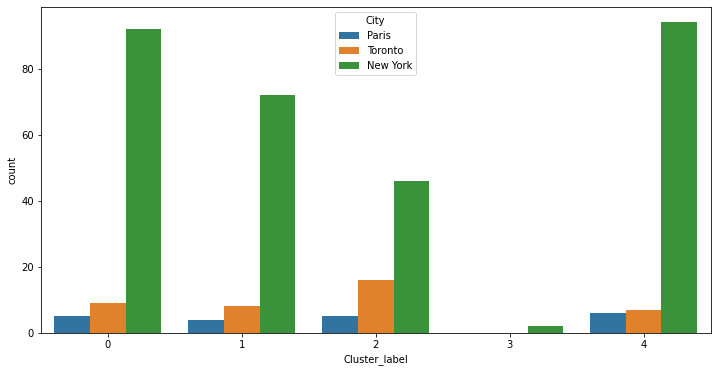

In [94]:
plt.figure(figsize=(12,6))



sns.countplot(x='Cluster_label',
              hue='City',
              data = df);

It appears that the clusters are identically distributed among the three cities, with an "outlier cluster" (number 4).

Let's visualize the clusters for each city.

In [112]:
def create_map_clusters(df, coord, kclusters):
    
    latitude, longitude = coord
    
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    markers_colors = []
    for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Cluster_label']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
       
    return map_clusters

In [108]:
paris_map_df = pd.merge(paris.drop(['Center_distance', 'Salary'], axis=1),
                        paris_neighborhoods_venues_sorted[['Neighborhood', 'Cluster_label']],
                        on='Neighborhood', how='left')

toronto_map_df = pd.merge(toronto.drop('Center_distance', axis=1),
                          toronto_neighborhoods_venues_sorted[['Neighborhood', 'Cluster_label']],
                          on='Neighborhood', how='left')

ny_map_df = pd.merge(ny.drop('Center_distance', axis=1),
                     ny_neighborhoods_venues_sorted[['Neighborhood', 'Cluster_label']],
                     on='Neighborhood', how='left')

In [115]:
paris_map_clusters = create_map_clusters(paris_map_df, paris_coord, 5)

toronto_map_clusters = create_map_clusters(toronto_map_df, toronto_coord, 5)

ny_map_clusters = create_map_clusters(ny_map_df, ny_coord, 5)

In [114]:
paris_map_clusters

In [116]:
toronto_map_clusters

In [117]:
ny_map_clusters

It seems the clusters are primarily determined by their location. It is not 100% though, as the location could also have an influence on the type of neighborhood and that could be the determining factor.

We have now concluded the clustering part, let's move to the correlation analysis.

# Correlation

In [96]:
paris_neighborhoods_venues_sorted.head()

,Cluster_label,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,Center_distance
0,2,01,Plaza,Art Museum,Hotel,Restaurant,Udon Restaurant,Historic Site,Garden,0.214696
1,0,02,Hotel,Cocktail Bar,French Restaurant,Salad Place,Historic Site,Perfume Shop,Women's Store,0.257141
2,2,03,Sandwich Place,French Restaurant,Wine Bar,Burger Joint,Italian Restaurant,Japanese Restaurant,Juice Bar,0.206442
3,2,04,French Restaurant,Ice Cream Shop,Coffee Shop,Wine Bar,Israeli Restaurant,Creperie,Cultural Center,0.099053
4,2,05,French Restaurant,Bar,Creperie,Italian Restaurant,Plaza,Hotel,Breakfast Spot,0.154917


In [97]:
paris_neighborhoods_venues_sorted['Cluster_label'].value_counts()

4    6
0    5
2    5
1    4
Name: Cluster_label, dtype: int64

In [98]:
paris_df = pd.merge(paris_neighborhoods_venues_sorted[['Neighborhood', 'Cluster_label']],
                    paris[['Neighborhood', 'Salary']],
                    on='Neighborhood')

paris_df.head()

,Neighborhood,Cluster_label,Salary
0,01,2,3168
1,02,0,2976
2,03,2,3038
3,04,2,2912
4,05,2,3123


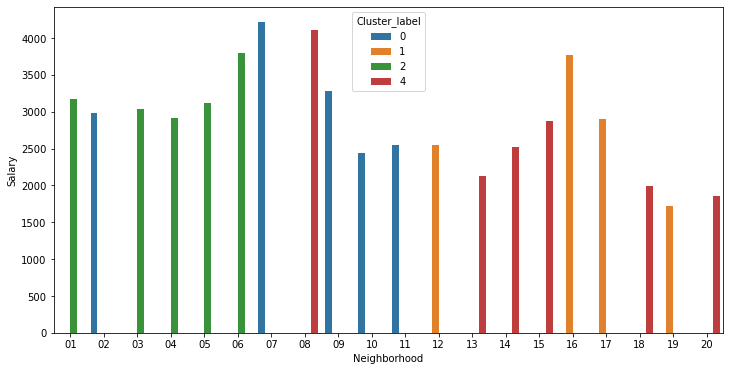

In [99]:
plt.figure(figsize=(12,6))

sns.barplot(x='Neighborhood', y='Salary',
            data=paris_df,
            hue='Cluster_label');

There does not appear to be a correlation. We should make sure using a statistical test.

In [100]:
import statsmodels.api


result = statsmodels.formula.api.ols('Cluster_label ~ Salary', data = paris_df).fit()
table = statsmodels.api.stats.anova_lm(result)

table

,df,sum_sq,mean_sq,F,PR(>F)
Salary,1.0,2.717709,2.717709,1.085099,0.31135
Residual,18.0,45.082291,2.504572,NaN,NaN


The p value is superior to 5%, we can thus not reject the hypothesis that the clusters we determined are not related to the salary levels of the neighborhoods.